# Gammapy Maps

![Gammapy Maps Illustration](images/gammapy_maps.png)

## Introduction
The [gammapy.maps](http://docs.gammapy.org/dev/maps/index.html) submodule contains classes for representing **sky images** with an **arbitrary number of non-spatial dimensions** such as energy, time, event class or any possible user-defined dimension (illustrated in the image above). The main `Map` data structure features a **uniform API** for [WCS](https://fits.gsfc.nasa.gov/fits_wcs.html) as well as [HEALPix](https://en.wikipedia.org/wiki/HEALPix) based images. The API also generalizes simple image based operations such as smoothing, interpolation and reprojection to the arbitrary extra dimensions and makes working with (2 + N)-dimensional hypercubes **as easy as working with a simple 2D image**. Further information is also provided on the [gammpy.maps](http://docs.gammapy.org/dev/maps/index.html) docs page.


In the following introduction we will **learn all the basics** of working with WCS based maps. HEALPix based maps will be covered in a future tutorial. We will cover the following topics in order:

1. [Creating WCS Maps](#1.-Creating-WCS-Maps)
1. [Accessing and Modifying Data](#2.-Accessing-and-Modifying-Data)
1. [Reading and Writing](#3.-Reading-and-Writing)
1. [Visualizing and Plotting](#4.-Visualizing-and-Plotting)
1. [Reprojecting, Interpolating and Miscellaneous](#5.-Reprojecting,-Interpolating-and-Miscellaneous)


Make sure you have worked through he [First Steps with Gammapy](first_steps.ipynb) and [Astropy Introduction](astropy_introduction.ipynb) notebooks, because a solid knowledge about working with `SkyCoords` and `Quantity` objects as well as [Numpy](http://www.numpy.org/) is required for this tutorial.

**Note:** This notebook is rather lengthy, but getting to know the `Map` data structure in detail is **essential for working with Gammapy** and will allow you to fulfill **complex analysis tasks with very few and simple code** in future!

##  0. Setup

--------------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from gammapy.maps import Map, MapAxis, WcsGeom

## 1. Creating WCS Maps

---------------------------------

### 1.1 Using Factory Methods

Maps are most easily created using the `Map.create()` factory method:

In [3]:
m_allsky = Map.create()

Calling `Map.create()` without any further arguments creates by default an allsky WCS map using a CAR projection, ICRS coordinates and a pixel size of 1 deg. This can be easily checked by printing the `.geom` attribute of the map:

In [4]:
print(m_allsky.geom)

WcsGeom

	axes       : lon, lat
	shape      : (3600, 1800)
	ndim       : 2
	coordsys   : CEL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 360.0 x 180.0 deg



The `.geom` attribute is a `MapGeom` object, that defines the basic geometry of the map, such as size of the pixels, width and height of the image, coordinate system etc., but we will learn more about this object later.

Besides the `.geom` attribute the map has also a `.data` attribute, which is just a plain `numpy.ndarray` and stores the data associated with this map:

In [5]:
m_allsky.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

By default maps are filled with zeros.

Here is a second example that creates a WCS map centered on the Galactic center and now uses Galactic coordinates:

In [6]:
skydir = SkyCoord(0, 0, frame="galactic", unit="deg")
m_gc = Map.create(
    binsz=0.02, width=(10, 5), skydir=skydir, coordsys="GAL", proj="TAN"
)
print(m_gc.geom)

WcsGeom

	axes       : lon, lat
	shape      : (500, 250)
	ndim       : 2
	coordsys   : GAL
	projection : TAN
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



In addition we have defined a TAN projection, a pixel size of `0.02` deg and a width of the map of `10 deg x 5 deg`. The `width` argument also takes scalar value instead of a tuple, which is interpreted as both the width and height of the map, so that a quadratic map is created.

### 1.2 Creating from a Map Geometry

As we have seen in the first examples, the `Map` object couples the data (stored as a `numpy.ndarray`) with a `MapGeom` object. The `MapGeom` object can be seen as a generalization of an `astropy.wcs.WCS` object, providing the information on how the data maps to physical coordinate systems. In some cases e.g. when creating many maps with the same WCS geometry it can be advantegeous to first create the map geometry independent of the map object itsself: 

In [7]:
wcs_geom = WcsGeom.create(
    binsz=0.02, width=(10, 5), skydir=(0, 0), coordsys="GAL"
)

And then create the map objects from the `wcs_geom` geometry specification:

In [8]:
maps = {}

for name in ["counts", "background"]:
    maps[name] = Map.from_geom(wcs_geom)

The `MapGeom` object also has a few helpful methods. E.g. we can check whether a given position on the sky is contained in the map geometry:

In [9]:
# define the position of the Galactic center and anti-center
positions = SkyCoord([0, 180], [0, 0], frame="galactic", unit="deg")
wcs_geom.contains(positions)

array([ True, False])

Or get the image center of the map:

In [10]:
wcs_geom.center_skydir

<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>

Or we can also retrieve the solid angle per pixel of the map:

In [11]:
wcs_geom.solid_angle()

<Quantity [[1.21730997e-07, 1.21730997e-07, 1.21730997e-07, ...,
            1.21730997e-07, 1.21730997e-07, 1.21730997e-07],
           [1.21732844e-07, 1.21732844e-07, 1.21732844e-07, ...,
            1.21732844e-07, 1.21732844e-07, 1.21732844e-07],
           [1.21734677e-07, 1.21734677e-07, 1.21734677e-07, ...,
            1.21734677e-07, 1.21734677e-07, 1.21734677e-07],
           ...,
           [1.21736496e-07, 1.21736496e-07, 1.21736496e-07, ...,
            1.21736496e-07, 1.21736496e-07, 1.21736496e-07],
           [1.21734677e-07, 1.21734677e-07, 1.21734677e-07, ...,
            1.21734677e-07, 1.21734677e-07, 1.21734677e-07],
           [1.21732844e-07, 1.21732844e-07, 1.21732844e-07, ...,
            1.21732844e-07, 1.21732844e-07, 1.21732844e-07]] sr>

### 1.3 Adding Non-Spatial Axes

In many analysis scenarios we would like to add extra dimension to the maps to study e.g. energy or time dependency of the data. Those non-spatial dimensions are handled with the `MapAxis` object. Let us first define an energy axis, with 4 bins:

In [12]:
energy_axis = MapAxis.from_bounds(
    1, 100, nbin=4, unit="TeV", name="energy", interp="log"
)
print(energy_axis)

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 4         
	node type  : edges     
	edges min  : 1.0e+00 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       



Where `interp='log'` specifies that a logarithmic spacing is used between the bins, equivalent to `np.logspace(0, 2, 4)`. This `MapAxis` object we can now pass to `Map.create()` using the `axes=` argument:

In [13]:
m_cube = Map.create(
    binsz=0.02, width=(10, 5), coordsys="GAL", axes=[energy_axis]
)
print(m_cube.geom)

WcsGeom

	axes       : lon, lat, energy
	shape      : (500, 250, 4)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



Now we see that besides `lon` and `lat` the map has an additional axes named `energy` with 4 bins. The total dimension of the map is now `ndim=3`.

We can also add further axes by passing a list of `MapAxis` objects. To demonstrate this we create a time axis with
linearly spaced bins and pass both axes to `Map.create()`:

In [14]:
time_axis = MapAxis.from_bounds(
    0, 24, nbin=24, unit="hour", name="time", interp="lin"
)

m_4d = Map.create(
    binsz=0.02, width=(10, 5), coordsys="GAL", axes=[energy_axis, time_axis]
)
print(m_4d.geom)

WcsGeom

	axes       : lon, lat, energy, time
	shape      : (500, 250, 4, 24)
	ndim       : 4
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



The `MapAxis` object internally stores the coordinates or "position values" associated with every map axis bin or "node". We distinguish between two node types: `edges` and `center`. The node type `edges`(which is also the default) specifies that the data associated with this axis is integrated between the edges of the bin (e.g. counts data). The node type `center` specifies that the data is given at the center of the bin (e.g. exposure or differential fluxes).

The edges of the bins can be checked with `.edges` attribute:

In [15]:
energy_axis.edges

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])

The numbers are given in the units we specified above, which can be checked again with:

In [16]:
energy_axis.unit

Unit("TeV")

The centers of the axis bins can be checked with the `.center` attribute:

In [17]:
energy_axis.center

array([ 1.77827941,  5.62341325, 17.7827941 , 56.23413252])

##  2. Accessing and Modifying Data

----------------------------------------------

### 2.1 Accessing Map Data Values

All map objects have a set of accessor methods, which can be used to access or update the contents of the map irrespective of its underlying representation. Those accessor methods accept as their first argument a coordinate `tuple` containing scalars, `list`, or `numpy.ndarray` with one tuple element for each dimension. Some methods additionally accept a `dict` or `MapCoord` argument, of which both allow to assign coordinates by axis name.

Let us first begin with the `.get_by_idx()` method, that accepts a tuple of indices. The order of the indices corresponds to the axis order of the map: 

In [18]:
m_gc.get_by_idx((50, 30))

array([0.], dtype=float32)

**Important:** Gammapy uses a reversed index order in the map API with the longitude axes first. To achieve the same by directly indexing into the numpy array we have to call:  

In [19]:
m_gc.data[([30], [50])]

array([0.], dtype=float32)

To check the order of the axes you can always print the `.geom` attribute:

In [20]:
print(m_gc.geom)

WcsGeom

	axes       : lon, lat
	shape      : (500, 250)
	ndim       : 2
	coordsys   : GAL
	projection : TAN
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



To access values directly by sky coordinates we can use the `.get_by_coord()` method. This time we pass in a `dict`, specifying the axes names corresponding to the given coordinates:

In [21]:
m_gc.get_by_coord({"lon": [0, 180], "lat": [0, 0]})

array([ 0., nan], dtype=float32)

The units of the coordinates are assumed to be in degrees in the coordinate system used by the map. If the coordinates do not correspond to the exact pixel center, the value of the nearest pixel center will be returned. For positions outside the map geometry `np.nan` is returned.

The coordinate or idx arrays follow normal [Numpy broadcasting rules](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html). So the following works as expected:



In [22]:
lons = np.linspace(-4, 4, 10)
m_gc.get_by_coord({"lon": lons, "lat": 0})

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Or as an even more advanced example, we can provide `lats` as column vector and broadcasting to a 2D result array will be applied:

In [23]:
lons = np.linspace(-4, 4, 8)
lats = np.linspace(-4, 4, 8).reshape(-1, 1)
m_gc.get_by_coord({"lon": lons, "lat": lats})

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

### 2.2 Modifying Map Data Values

To modify and set map data values the `Map` object features as well a `.set_by_idx()` method: 


In [24]:
m_cube.set_by_idx(idx=(10, 20, 3), vals=42)

In [25]:
m_cube.get_by_idx((10, 20, 3))

array([42.], dtype=float32)

Of course there is also a `.set_by_coord()` method, which allows to set map data values in physical coordinates. 

In [26]:
m_cube.set_by_coord({"lon": 0, "lat": 0, "energy": 2 * u.TeV}, vals=42)

Again the `lon` and `lat` values are assumed to be given in degrees in the coordinate system used by the map. For the energy axis, the unit is the one specified on the axis (use `m_cube.geom.axes[0].unit` to check if needed...)

All `.xxx_by_coord()` methods accept `SkyCoord` objects as well. In this case we have to use the `skycoord` keyword instead of `lon` and `lat`:

In [27]:
skycoords = SkyCoord([1.2, 3.4], [-0.5, 1.1], frame="galactic", unit="deg")
m_cube.set_by_coord({"skycoord": skycoords, "energy": 2 * u.TeV}, vals=42)

### 2.3 Indexing and Slicing Sub-Maps

When you have worked with Numpy arrays in the past you are probably familiar with the concept of indexing and slicing
into data arrays. To support slicing of non-spatial axes of `Map` objects, the `Map` object has a `.slice_by_idx()` method, which allows to extract sub-maps from a larger map.

The following example demonstrates how to get the map at the energy bin number 3:  

In [28]:
m_sub = m_cube.slice_by_idx({"energy": 3})
print(m_sub)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (500, 250)
	ndim  : 2
	unit  : '' 
	dtype : float32 



Note that the returned object is again a `Map` with updated axes information. In this case, because we extracted only a single image, the energy axes is dropped from the map.

To extract a sub-cube with a sliced energy axes we can use a normal `slice()` object:

In [29]:
m_sub = m_cube.slice_by_idx({"energy": slice(1, 3)})
print(m_sub)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 250, 2)
	ndim  : 3
	unit  : '' 
	dtype : float32 



Note that the returned object is also a `Map` object, but this time with updated energy axis specification.

Slicing of multiple dimensions is supported by adding further entries to the dict passed to `.slice_by_idx()`

In [30]:
m_sub = m_4d.slice_by_idx({"energy": slice(1, 3), "time": slice(4, 10)})
print(m_sub)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy, time
	shape : (500, 250, 2, 6)
	ndim  : 4
	unit  : '' 
	dtype : float32 



For convenience there is also a `.get_image_by_coord()` method which allows to access image planes at given non-spatial physical coordinates. This method also supports `Quantity` objects:

In [31]:
image = m_4d.get_image_by_coord({"energy": 4 * u.TeV, "time": 5 * u.h})
print(image.geom)

WcsGeom

	axes       : lon, lat
	shape      : (500, 250)
	ndim       : 2
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 5.0 deg



##  3. Reading and Writing

----------------------------------

Gammapy `Map` objects are serialized using the Flexible Image Transport Format (FITS). Depending on the pixelisation scheme (HEALPix or WCS) and presence of non-spatial dimensions the actual convention to write the FITS file is different.
By default Gammpy uses a generic convention named `gadf`, which will support WCS and HEALPix formats as well as an arbitrary number of non-spatial axes. The convention is documented in detail on the [Gamma Astro Data Formats](https://gamma-astro-data-formats.readthedocs.io/en/latest/skymaps/index.html) page.

Other conventions required by specific software (e.g. the Fermi Science Tools) are supported as well. At the moment those are the following
* `fgst-ccube`: Fermi counts cube format.
* `fgst-ltcube`: Fermi livetime cube format.
* `fgst-bexpcube`: Fermi exposure cube format
* `fgst-template`: Fermi Galactic diffuse and source template format. 
* `fgst-srcmap` and `fgst-srcmap-sparse`: Fermi source map and sparse source map format.

The conventions listed above only support an additional energy axis. 

### 3.1 Reading Maps

Reading FITS files is mainly exposed via the `Map.read()` method.Let us take a look at a first example: 

In [32]:
filename = "$GAMMAPY_EXTRA/datasets/fermi_2fhl/fermi_2fhl_gc.fits.gz"
m_2fhl_gc = Map.read(filename)
print(m_2fhl_gc)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (320, 180)
	ndim  : 2
	unit  : '' 
	dtype : >f8 



By default `Map.read()` will try to find the first valid data hdu in the filename and read the data from there. If mutliple HDUs are present in the FITS file, the desired one can be chosen with the additional `hdu=` argument:

In [33]:
m_2fhl_gc = Map.read(filename, hdu="background")
print(m_2fhl_gc)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (320, 180)
	ndim  : 2
	unit  : '' 
	dtype : >f8 



In rare cases e.g. when the FITS file is not valid or meta data is missing from the header it can be necessary to modify the header of a certain HDU before creating the `Map` object. In this case we can use `astropy.io.fits` directly to read the FITS file:

In [34]:
hdulist = fits.open("../datasets/fermi_survey/all.fits.gz")
hdulist.info()

Filename: ../datasets/fermi_survey/all.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  COUNTS        1 PrimaryHDU      84   (2001, 101)   int32   
  1  BACKGROUND    1 ImageHDU        85   (2001, 101)   float64   
  2  EXPOSURE      1 ImageHDU        85   (2001, 101)   float32   


And then modify the header keyword and use `Map.from_hdulist()` to create the `Map` object after:

In [35]:
hdulist["exposure"].header["BUNIT"] = "cm2 s"
Map.from_hdulist(hdulist=hdulist, hdu="exposure")

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (2001, 101)
	ndim  : 2
	unit  : 'cm2 s' 
	dtype : >f4 

### 3.2 Writing Maps

Writing FITS files is mainoy exposure via the `Map.write()` method. Here is a first example:

In [36]:
m_cube.write("example_cube.fits", overwrite=True)

By default Gammapy does not overwrite files. In this example we set `overwrite=True` in case the cell gets executed multiple times. Now we can read back the cube from disk using `Map.read()`:

In [37]:
m_cube = Map.read("example_cube.fits")
print(m_cube)

WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 250, 4)
	ndim  : 3
	unit  : '' 
	dtype : >f4 



We can also choose a different FITS convention to write the example cube in a format compatible to the Fermi Galactic diffuse background model:

In [38]:
m_cube.write("example_cube_fgst.fits", conv="fgst-template", overwrite=True)

To understand a little bit better the generic `gadf` convention we use `Map.to_hdulist()` to generate a list of FITS HDUs first:   

In [39]:
hdulist = m_4d.to_hdulist(conv="gadf")
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (500, 250, 4, 24)   float32   
  1  PRIMARY_BANDS    1 BinTableHDU     31   96R x 7C   ['I', 'E', 'E', 'E', 'E', 'E', 'E']   


As we can see the `HDUList` object contains to HDUs. The first one named `PRIMARY` contains the data array with shape corresponding to our data and the WCS information stored in the header:

In [40]:
hdulist["PRIMARY"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                  500                                                  
NAXIS2  =                  250                                                  
NAXIS3  =                    4                                                  
NAXIS4  =                   24                                                  
EXTEND  =                    T                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                250.5 / Pixel coordinate of reference point            
CRPIX2  =                125.5 / Pixel coordinate of reference point            
CDELT1  =                -0.02 / [deg] Coordinate increment at reference point  
CDELT2  =                 0.

The second HDU is a `BinTableHDU` named `PRIMARY_BANDS` contains the information on the non-spatial axes such as name, order, unit, min, max and center values of the axis bins. We use an `astropy.table.Table` to show the information:

In [41]:
Table.read(hdulist["PRIMARY_BANDS"])

CHANNEL,ENERGY,E_MIN,E_MAX,TIME,T_MIN,T_MAX
,TeV,TeV,TeV,h,h,h
int16,float32,float32,float32,float32,float32,float32
0,1.7782794,1.0,3.1622777,0.5,0.0,1.0
1,5.623413,3.1622777,10.0,0.5,0.0,1.0
2,17.782795,10.0,31.622776,0.5,0.0,1.0
3,56.23413,31.622776,100.0,0.5,0.0,1.0
4,1.7782794,1.0,3.1622777,1.5,1.0,2.0
5,5.623413,3.1622777,10.0,1.5,1.0,2.0
6,17.782795,10.0,31.622776,1.5,1.0,2.0
7,56.23413,31.622776,100.0,1.5,1.0,2.0


##  4. Visualizing and Plotting

--------------------------------------

### 4.1 Plotting 

For debugging and inspecting the map data it is useful to plot ot visualize the images planes contained in the map. 

In [42]:
filename = "$GAMMAPY_EXTRA/datasets/fermi_2fhl/fermi_2fhl_gc.fits.gz"
m_2fhl_gc = Map.read(filename, hdu="counts")

After reading the map we can now plot it on the screen by calling the `.plot()` method:

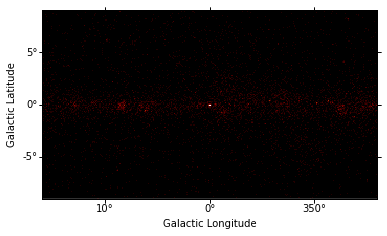

In [43]:
m_2fhl_gc.plot();

We can easily improve the plot by calling `Map.smooth()` first and providing additional arguments to `.plot()`. Most of them are passed further to [plt.imshow()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html):

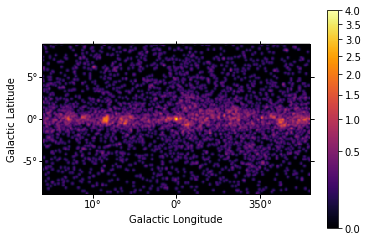

In [44]:
smoothed = m_2fhl_gc.smooth(radius=0.2 * u.deg, kernel="gauss")
smoothed.plot(stretch="sqrt", add_cbar=True, vmax=4, cmap="inferno");

We can use the [plt.rc_context()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.rc_context.html) context manager to further tweak the plot by adapting the figure and font size:

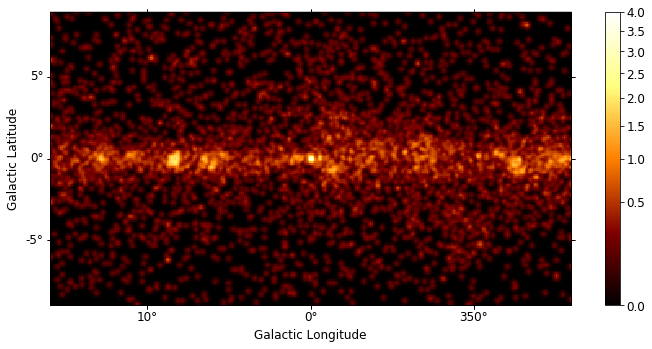

In [45]:
rc_params = {"figure.figsize": (12, 5.4), "font.size": 12}
with plt.rc_context(rc=rc_params):
    smoothed = m_2fhl_gc.smooth(radius=0.2 * u.deg, kernel="gauss")
    smoothed.plot(stretch="sqrt", add_cbar=True, vmax=4);

### 4.2 Interactive Plotting 

For maps with non-spatial dimensions the `Map` object features an interactive plotting method, that works in jupyter notebooks only (**Note:** it requires the package `ipywidgets` to be installed). We first read a small example cutout from the Fermi Galactic diffuse model and display the data cube by calling `.plot_interactive()`:

In [46]:
filename = "$GAMMAPY_EXTRA/datasets/fermi_3fhl/gll_iem_v06_cutout.fits"
m_iem_gc = Map.read(filename)

rc_params = {
    "figure.figsize": (12, 5.4),
    "font.size": 12,
    "axes.formatter.limits": (2, -2),
}
m_iem_gc.plot_interactive(add_cbar=True, stretch="sqrt", rc_params=rc_params)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

Now you can use the interactive slider to select an energy range and the corresponding image is diplayed on the screen. You can also use the radio buttons to select your preferred image stretching. We have passed additional keywords using the `rc_params` argument to improve the figure and font size. Those keywords are directly passed to the [plt.rc_context()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.rc_context.html) context manager.

##  5. Reprojecting, Interpolating and Miscellaneous

-------------------------------------------------------------------

### 5.1 Reprojecting to Different Map Geometries

The example map `m_iem_gc` is given in Galactic coordinates:

In [47]:
print(m_iem_gc.geom)

WcsGeom

	axes       : lon, lat, energy
	shape      : (88, 48, 30)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, -0.1 deg
	width      : 11.0 x 6.0 deg



As an example we will now extract the image at `~10 GeV` and reproject it to ICRS coordinates. For this we first define the target map WCS geometry. As `.reproject()` only applies to the spatial axes, we do not have to specify any additional non-spatial axes:

In [48]:
skydir = SkyCoord(266.4, -28.9, frame="icrs", unit="deg")
wcs_geom_cel = WcsGeom.create(
    skydir=skydir, binsz=0.1, coordsys="CEL", width=(8, 4)
)

Then we extract the image at `~10 GeV`, reproject to the target geometry and plot the result:

(<matplotlib.figure.Figure at 0x7f6a3f7586d8>,
 <matplotlib.colorbar.Colorbar at 0x7f6a3ec76278>)

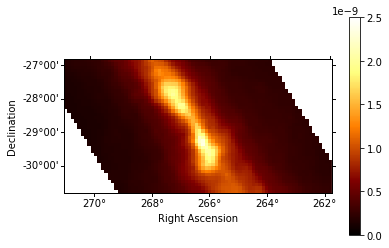

In [49]:
m_iem = m_iem_gc.get_image_by_coord({"energy": 10 * u.GeV})
m_iem_cel = m_iem.reproject(wcs_geom_cel)
m_iem_cel.plot(add_cbar=True, vmin=0, vmax=2.5e-9)

### 5.2 Interpolating Map Values

While for the reprojection example above we used `.get_image_by_coord()` to extract the closest image to `~10 GeV`, we can use the more general method `.interp_by_coord()` to interpolate in the energy axis as well. For this we first define again the target map geometry:

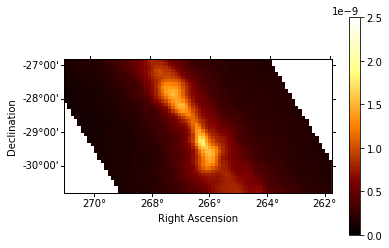

In [50]:
m_iem_10GeV = Map.from_geom(wcs_geom_cel)
coords = m_iem_10GeV.geom.get_coord()

m_iem_10GeV.data = m_iem_gc.interp_by_coord(
    {"skycoord": coords.skycoord, "energy": 10 * u.GeV},
    interp="linear",
    fill_value=np.nan,
)
m_iem_10GeV.plot(add_cbar=True, vmin=0, vmax=2.5e-9);

### 5.3 Making Cutouts

The `WCSNDMap` objects features a `.cutout()` method, which allows you to cut out a smaller part of a larger map. This can be useful, e.g. when working with allsky diffuse maps. Here is an example: 

In [51]:
position = SkyCoord(0, 0, frame="galactic", unit="deg")
m_iem_cutout = m_iem_gc.cutout(position=position, width=(4 * u.deg, 2 * u.deg))

rc_params = {
    "figure.figsize": (12, 5.4),
    "font.size": 12,
    "axes.formatter.limits": (2, -2),
}
m_iem_cutout.plot_interactive(
    add_cbar=True, rc_params=rc_params, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

The returned object is again a `Map` object with udpated WCS information and data size. As one can see the cutout is automatically applied to all the non-spatial axes as well. The cutout width is given in the order of `(lon, lat)` and can be specified with units that will be handled correctly. 